In [55]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import tensorflow as tf

In [56]:
R = 1
n = 3
l = 2

In [57]:
num_dense_nodes = 50
num_dense_layers = 7

In [58]:
def pde(x, y):
    dy_r = dde.grad.jacobian(y, x, i=0, j=0)
    dy_rr = dde.grad.hessian(y, x, i=0, j=0)
    
    k = sp.jn_zeros(l, n)[-1] 
    
    return (x ** 2) * dy_rr + x * dy_r + ((x ** 2) * (k ** 2) - (l ** 2)) * y

In [59]:
def angular(theta):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(theta * l * 1j)

In [60]:
def radial(r):
    normalization_constant = np.sqrt(2) / (R * np.abs(sp.jn_zeros(l + 1, n)[-1]))
    bessel = sp.jv(l, sp.jn_zeros(l, n)[-1] * (r / R))

    return normalization_constant * bessel

In [61]:
def psi(x):
    r, theta = x[:, 0:1], x[:, 1:2]
    
    radial_part = radial(r)
    angular_part = angular(theta)

    return radial_part * angular_part

In [62]:
domain = dde.geometry.Interval(0, R)

In [63]:
def get_collocation_points(n):
    rs = []
    
    r_interval = R / (3 * n)
    
    for k in range(3 * n - 1):
        r = (k + 1) * r_interval
        rs.append(r)
    
    return np.array(rs).reshape((3 * n - 1, 1))

In [64]:
collocation_points = get_collocation_points(n)
collocation_values = radial(collocation_points)

collocation_values

array([[ 0.01965502],
       [ 0.04963942],
       [ 0.04279143],
       [-0.00105808],
       [-0.03308733],
       [-0.01918937],
       [ 0.01659829],
       [ 0.02600135]])

In [65]:
ic = dde.icbc.PointSetBC(collocation_points, collocation_values)

In [66]:
def boundary(x, on_boundary):
    return on_boundary

def boundary_value(x):
    return 0

def boundary_derivative_value(x):
    alpha = sp.jn_zeros(l, n)[-1]
    normalization_constant = (alpha / R) * np.sqrt(2) / (R * np.abs(sp.jn_zeros(l + 1, n)[-1]))
    return normalization_constant * sp.jvp(l, alpha * x / R)

dirichlet_bc = dde.icbc.DirichletBC(domain, boundary_value, boundary)
neumann_bc = dde.icbc.NeumannBC(domain, boundary_derivative_value, boundary)

In [67]:
bcs = [ic, dirichlet_bc, neumann_bc]

In [68]:
num_train = 64
num_test = 100
num_boundary = 2

singularity = [0.0]

data = dde.data.PDE(
    domain, 
    pde, 
    bcs, 
    num_domain=num_train,
    num_boundary=num_boundary,
    solution=radial, 
    num_test=num_test,
    exclusions=singularity
)

In [69]:
activation = 'tanh'
net = dde.nn.FNN(
    [1] + [num_dense_nodes] * num_dense_layers + [1], 
    activation, 
    'Glorot uniform'
)

In [70]:
loss_weights = [1, 100, 100, 100]

model = dde.Model(data, net)
model.compile(
    'adam', 
    lr=0.0001, 
    metrics=['l2 relative error'], 
    loss_weights=loss_weights
)

Compiling model...
Building feed-forward neural network...
'build' took 0.158521 s



2023-05-15 13:12:07.570914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-15 13:12:07.571253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-15 13:12:07.571503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'compile' took 0.966713 s



In [71]:
loss_history, train_state = model.train(iterations=20000)

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [7.00e+01, 1.17e+00, 2.65e+00, 2.83e+00]    [6.59e+01, 1.17e+00, 2.65e+00, 2.83e+00]    [3.92e+00]    
1000      [7.34e-01, 2.96e-01, 2.70e-02, 1.98e-01]    [6.36e-01, 2.96e-01, 2.70e-02, 1.98e-01]    [1.94e+00]    
2000      [2.34e-01, 9.91e-02, 4.77e-04, 7.80e-03]    [1.83e-01, 9.91e-02, 4.77e-04, 7.80e-03]    [1.45e+00]    
3000      [1.65e-01, 5.99e-02, 7.43e-03, 7.38e-03]    [1.44e-01, 5.99e-02, 7.43e-03, 7.38e-03]    [1.13e+00]    
4000      [3.62e-02, 1.29e-02, 1.57e-03, 3.56e-04]    [3.14e-02, 1.29e-02, 1.57e-03, 3.56e-04]    [4.77e-01]    
5000      [3.47e-02, 9.54e-03, 3.26e-03, 1.07e-03]    [3.33e-02, 9.54e-03, 3.26e-03, 1.07e-03]    [3.93e-01]    
6000      [2.72e-02, 7.53e-03, 1.40e-03, 1.95e-04]    [2.32e-02, 7.53e-03, 1.40e-03, 1.95e-04]    [3.35e-01]    
7000      [2.46e-02, 6.11e-03, 1.36e-03, 1.63e-04] 

Saving loss history to /home/piotr/repos/quant-chem-pinns/potential-well/2d/circle/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/potential-well/2d/circle/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/potential-well/2d/circle/test.dat ...


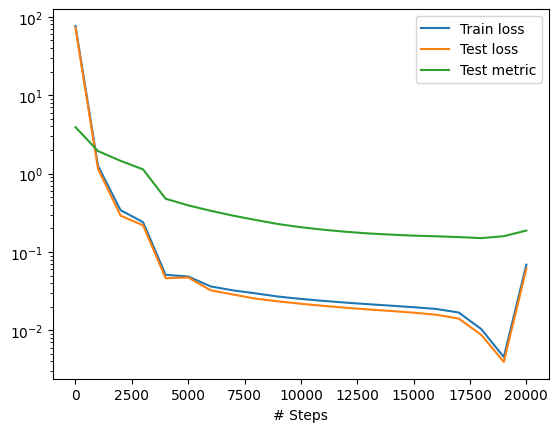

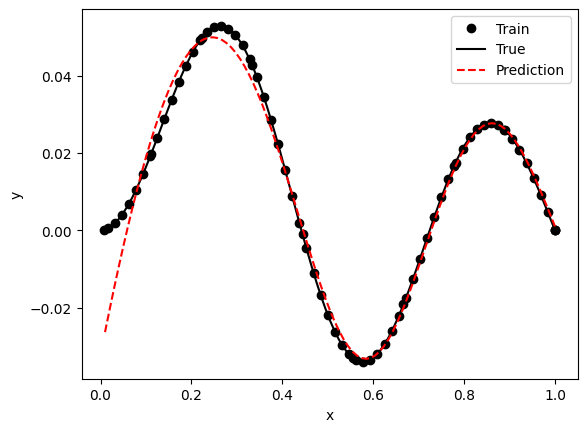

In [72]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [73]:
def psi_model(x):
    r, theta = x[:, 0:1], x[:, 1:2]
    radial_part = model.predict(r)
    angular_part = angular(theta)
    
    return radial_part * angular_part

In [74]:
def diff_function(x):
    model_value = psi_model(x)
    true_value = psi(x)
    return np.abs(model_value - true_value)

In [75]:
diff_function(np.array([[0.0, 0.0], [1.0, 0.0]]))

array([[0.01317407],
       [0.00159813]])

In [76]:
def plot_2d_map(plotted_function, grid_dist=0.01):
    x_ax = np.arange(0, R, grid_dist)
    y_ax = np.arange(0, 2 * np.pi, grid_dist)
    grid_x, grid_y = np.meshgrid(x_ax, y_ax)
    
    diff_list = []
    for a, b in zip(grid_x, grid_y):
        pair_list = []
        for x, y in zip(a, b):
            pair_list.append([x, y])
        pairs = np.array(pair_list)
        diff_list.append(np.squeeze(plotted_function(pairs)))

    diff_list = np.abs(np.array(diff_list))
    
    im = plt.imshow(diff_list, cmap=plt.cm.RdBu)
    plt.colorbar(im)

    plt.show()

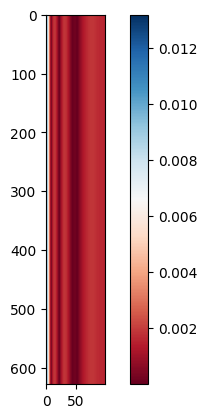

In [77]:
plot_2d_map(diff_function)

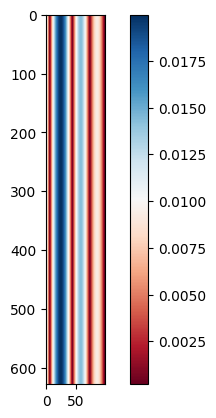

In [78]:
plot_2d_map(psi_model)

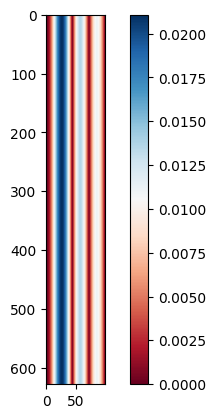

In [79]:
plot_2d_map(psi)